In [76]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [77]:
tf.logging.set_verbosity(tf.logging.INFO)

# Import Data and Preprocessing

In [78]:
def load_data(target):
    names=os.listdir(target)
    x=[]
    y=[]
    for i in names:
        path_target=os.path.join(target,i)
        path_image=os.listdir(path_target)
        for j in path_image:
            path_final=os.path.join(path_target,j)
            img=cv2.imread(path_final,0)
            img=cv2.resize(img,(32,32))
            x.append(img)
            y.append(i)
    return x,y

In [79]:
x_train,y_train=load_data("train/")
x_test,y_test=load_data("validation/")

In [80]:
x_train=np.array(x_train).astype("float32")
y_train=np.array(y_train)
x_test=np.array(x_test).astype("float32")
y_test=np.array(y_test)

In [81]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(1955, 32, 32) (1955,) (655, 32, 32) (655,)


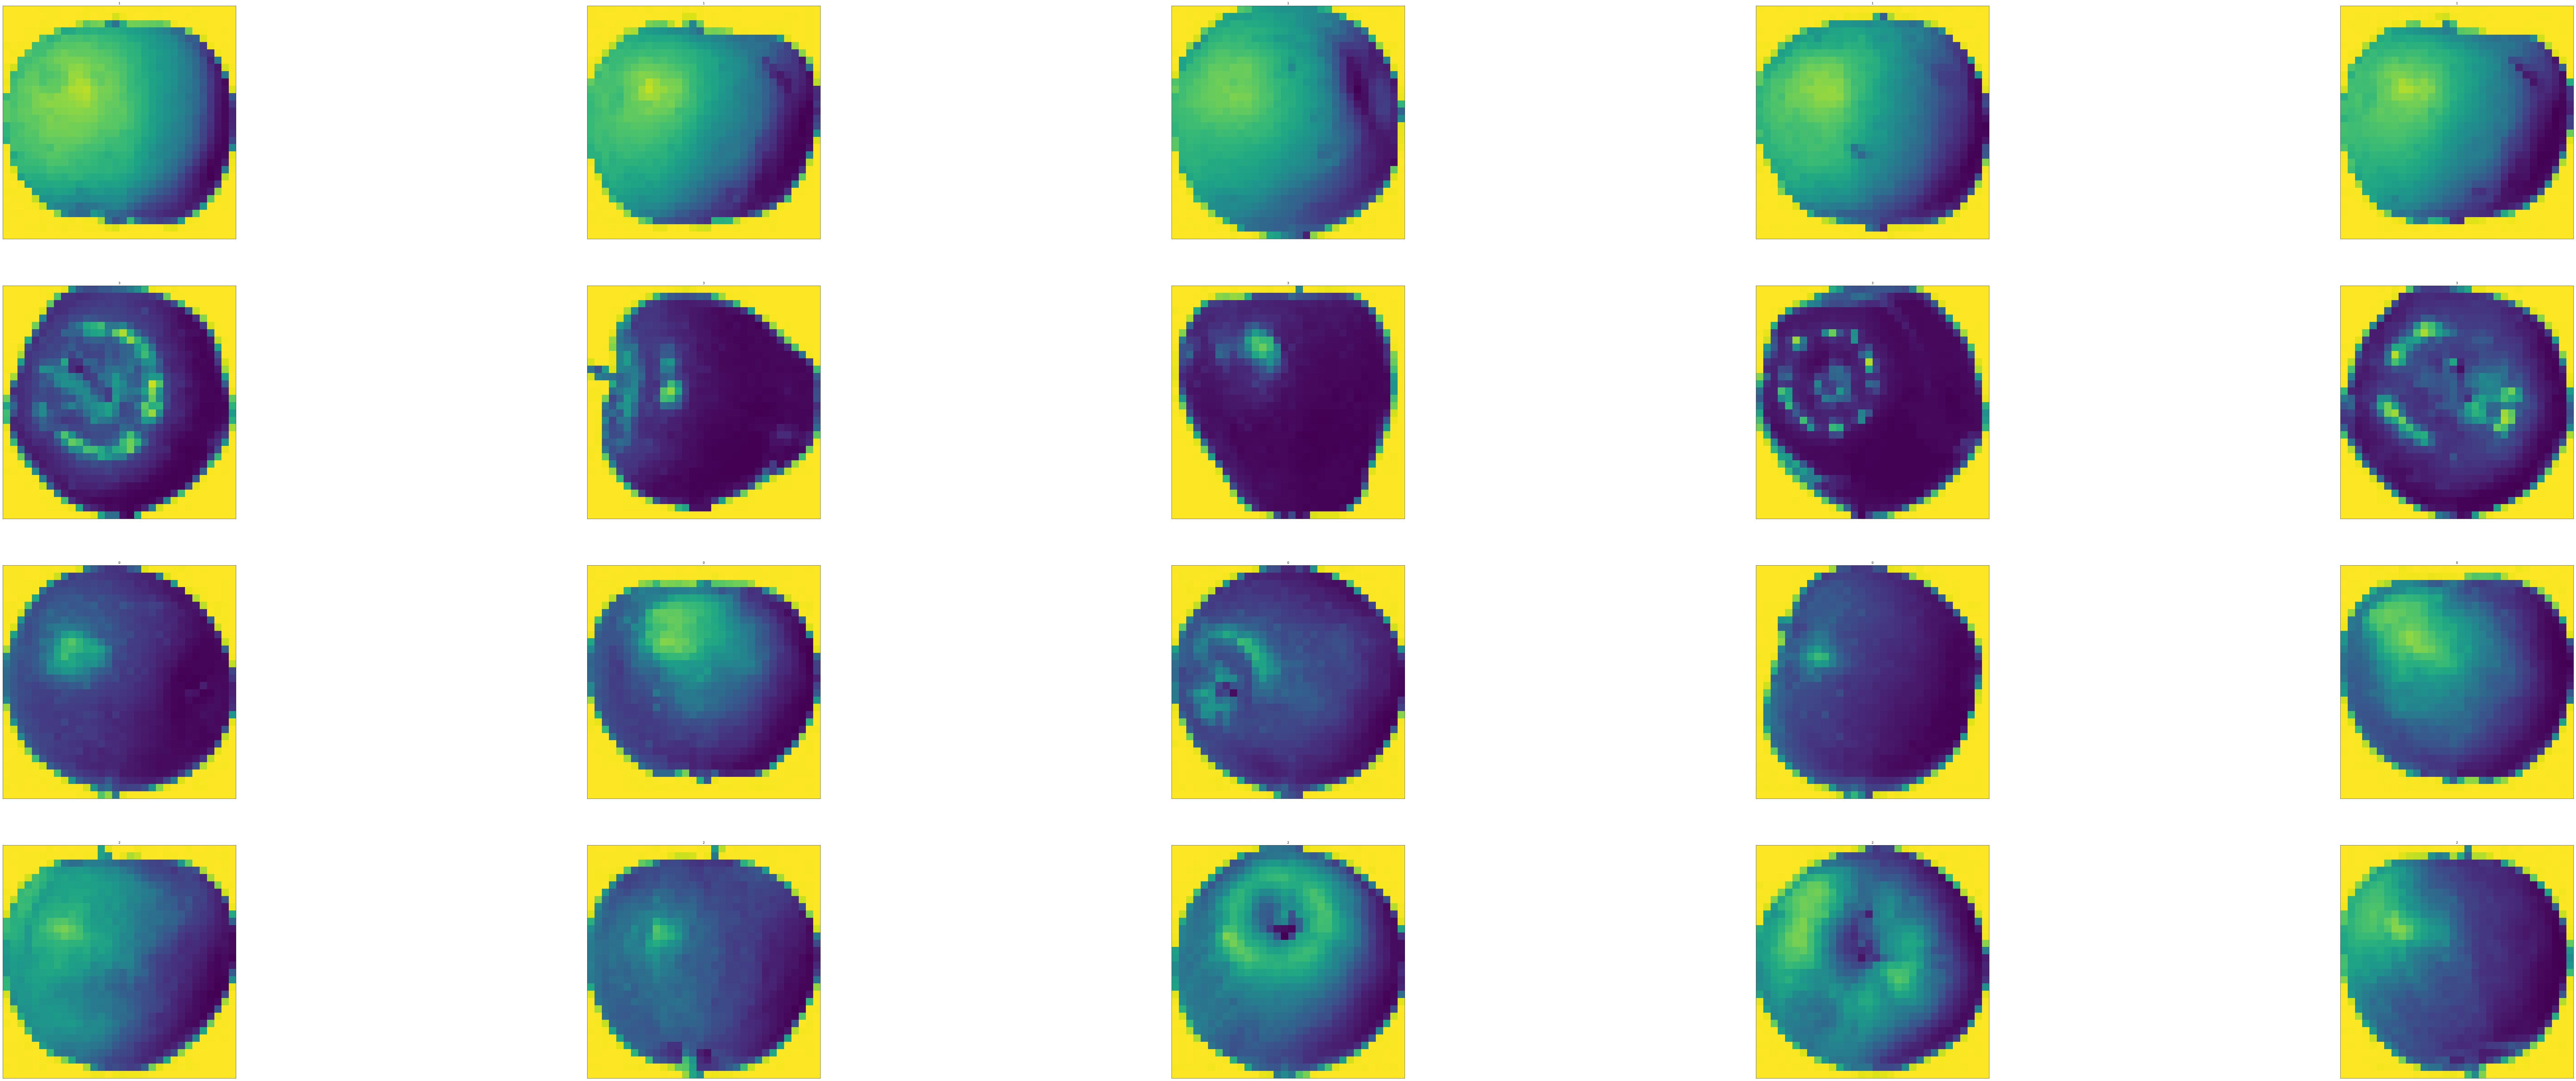

In [93]:
plt.figure(figsize=[200,200])
for i in range(1,1955,100):
    plt.subplot(10,5,i/100 +1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    plt.xticks([]), plt.yticks([]) 

In [82]:
np.unique(y_train)

array(['Apple Braeburn', 'Apple Golden', 'Apple Red',
       'Apple Red Delicious'], dtype='<U19')

In [83]:
def sub(data):
    data=pd.DataFrame(data,columns=["type"])
    a={'Apple Braeburn':0, 'Apple Golden':1,'Apple Red':2, 'Apple Red Delicious':3}
    data= data["type"].map(a)
    return data.values
    

In [84]:
y_train=sub(y_train)
y_test=sub(y_test)

In [85]:
x_train=x_train/255
x_test=x_test/255

In [86]:
y_train=y_train.astype("int32")
y_test=y_test.astype("int32")

# CNN Function

In [87]:

def cnn_model_fn(features, labels, mode):
    
    input_layer = tf.reshape(features["x"], [-1, 32, 32, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.layers.flatten(pool2)
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout1 = tf.layers.dropout(inputs=dense1, rate=0.45, training=mode == tf.estimator.ModeKeys.TRAIN)
    dense2 = tf.layers.dense(inputs=dropout1, units=512, activation=tf.nn.relu) 
    dropout2 = tf.layers.dropout(inputs=dense2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout1, units=10)

    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



# Create Customized Estimator, train and Evaluate

In [88]:
apple_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/apple_cla1")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f94e937bb00>, '_tf_random_seed': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_model_dir': '/tmp/apple_cla1', '_save_checkpoints_secs': 600, '_is_chief': True, '_service': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_master': '', '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000}


In [89]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": x_train},
      y=y_train,
      batch_size=100,
      num_epochs=None,shuffle=True)

In [90]:
apple_classifier.train(input_fn=train_input_fn, steps=5000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/apple_cla1/model.ckpt.
INFO:tensorflow:loss = 2.278905, step = 1
INFO:tensorflow:global_step/sec: 2.71521
INFO:tensorflow:loss = 1.670917, step = 101 (36.830 sec)
INFO:tensorflow:global_step/sec: 2.73845
INFO:tensorflow:loss = 1.2739278, step = 201 (36.517 sec)
INFO:tensorflow:global_step/sec: 2.69854
INFO:tensorflow:loss = 1.1569476, step = 301 (37.057 sec)
INFO:tensorflow:global_step/sec: 2.72671
INFO:tensorflow:loss = 1.1087607, step = 401 (36.674 sec)
INFO:tensorflow:global_step/sec: 2.72417
INFO:tensorflow:loss = 0.95869803, step = 501 (36.708 sec)
INFO:tensorflow:global_step/sec: 2.70916
INFO:tensorflow:loss = 0.8519254, step = 601 (36.912 sec)
INFO:tensorflow:global_step/sec: 2.73624
INFO:tensorflow:loss = 0.96126753, step = 701 (36.547 sec)
INFO:tensorflow:global_step/sec: 2.7286
INFO:tensorflow:loss = 0.73069686, step = 801 (36.649 sec)
INFO:tensorflow:global_step/sec: 2.6942
INFO:te

In [91]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": x_test},
      y=y_test,
      num_epochs=1,
      shuffle=False)
eval_results = apple_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)


INFO:tensorflow:Starting evaluation at 2018-02-07-21:46:46
INFO:tensorflow:Restoring parameters from /tmp/apple_cla1/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-02-07-21:46:47
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.90076333, global_step = 5000, loss = 0.51279265
{'loss': 0.51279265, 'accuracy': 0.90076333, 'global_step': 5000}


In [45]:
y_test.shape

(1619,)

In [46]:
x_test.shape

(1619, 32, 32)